In [1]:
# This is to set up necessary dependencies, and make sure currenyt versions are installed
!pip3 install torch torchvision
!pip3 install Pillow

# NOTE: it could be needed to restart the runtime after this step if PIL related errors are encountered later during training

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61188000 @  0x7f47252bd2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 15.6MB/s 
    100% |████████████████████████████████| 2.0MB 3.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
# Download the data
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip flower_data.zip

# I found it useful and convenient to save the model on Google Drive.
# This links the drive to this notebook
from google.colab import drive
drive.mount('/content/gdrive')


--2018-12-17 19:04:29--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  84.0MB/s    in 3.7s    

2018-12-17 19:04:33 (80.1 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

Archive:  flower_data.zip
   creating: flower_data/
   creating: flower_data/valid/
   creating: flower_data/valid/61/
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/valid/61/image_06273.jpg  
   creating: flower_data/valid/95/
 

In [0]:
# Main imports
import numpy as np
import time
import torch
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [0]:
# Training ad data loader creation, based on the selected pre-trained model
def create_loaders(base, final = False):

    # Setting up pathnames to training and test data
    data_dir = 'flower_data'
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'

    # creating transforms for pre-processing
    # Different pre-trained models expect different img sizes
    # ResNet, DenseNet expect 224, Inception expects 299
    if base == 'ResNet':
        img_size = 224
    elif base == 'DenseNet161':
        img_size = 224
    elif base == 'Inception':
        img_size = 299
    else:
        img_size = 224

    transforms_train = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(img_size),    # Change this depending on what the model expects as input
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    transforms_test = transforms.Compose([
        transforms.Resize(img_size + 1),           # Change this depending on what the model expects as input
        transforms.CenterCrop(img_size),           # Change this depending on what the model expects as input
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    # Load the datasets with ImageFolder
    datasets_train = datasets.ImageFolder(train_dir, transform=transforms_train)
    datasets_test = datasets.ImageFolder(valid_dir, transform=transforms_test)

    if final == False:
        # Create indeces in training data to split off a portion for validation
        valid_size = 0.2
        num_train = len(datasets_train)
        indices = list(range(num_train))
        np.random.shuffle(indices)
        split = int(np.floor(valid_size * num_train))
        train_idx, valid_idx = indices[split:], indices[:split]

        # define samplers for obtaining training and validation batches
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        # Using the image datasets and the trainforms, define the dataloaders
        train_loader = torch.utils.data.DataLoader(datasets_train, batch_size=64, sampler=train_sampler)
        valid_loader = torch.utils.data.DataLoader(datasets_train, batch_size=64, sampler=valid_sampler)
    else:
        train_loader = torch.utils.data.DataLoader(datasets_train, batch_size=64, shuffle = True)
        valid_loader = torch.utils.data.DataLoader(datasets_test, batch_size=64, shuffle = True)

    # This is used for testing the trained non-final model. Final models are trained on whole train set, using test set for validation
    test_loader = torch.utils.data.DataLoader(datasets_test, batch_size=64, shuffle = True)
    
    return train_loader, valid_loader, test_loader

In [0]:
""" Defining possible architectures of the final classifier. 
Instances of these classes will be used to replace the final layer of imported CNN.
H2 has 2 hidden layers, H1 has one. Overall, H1 seemed to get better accuracy at this job. """

class ClassifierH2(nn.Module):
    def __init__(self, inp = 2048, h1=1024, h2=512, out = 102, d=0.3):
        super().__init__()
        self.fc1 = nn.Linear(inp, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, out)
        
        self.dropout = nn.Dropout(d)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)            
        x = self.fc3(x)
        
        return x
      
class ClassifierH1(nn.Module):
    def __init__(self, inp = 2048, h1=1024, out = 102, d=0.3):
        super().__init__()
        self.fc1 = nn.Linear(inp, h1)
        self.fc2 = nn.Linear(h1, out)
        
        self.dropout = nn.Dropout(d)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)        
        x = self.fc2(x)
        
        return x


In [0]:
""" I build the final model from 2 parts: imported pre-trained CNN - like ResNet - that is used for feature detection, 
and a customized classifier for final probability scoring. To make experimentation with training easier, I created a special 
container class that is used for three main things:
    - holds reference to imported CNN (with final layer replaced)
    - holds reference to custom classifier
    - has a number of utility features and methods to help with training and progress tracking """

class MyNetwork():
       
    def __init__(self, base, clf, kwargs):
        # Additional variables will be used to track training progress for easier re-loads, plotting, etc.
        self.last_epoch = 0       # Keeps track of number of epochs trained
        self.min_vloss = np.inf   # Keeps track of lowest validation loss
        self.lr_hist = []         # Tracks learn rate changes over epochs 
        self.vloss_hist = []      # Tracks validation loss changes over epochs
        self.tloss_hist = []      # Tracks training loss changes over epochs
        self.acc_hist = []        # Tracks accuracy rate changes over epochs
        self.opt_dict = None      # Stores optimezer dictionary
        self.sch_dict = None      # Stores scheduler dictionary
        self.sch_wait = None      # Stores scheduler "patience" parameter
        self.clf_name = clf       # Stores the name of the chosen classifier
        self.base_name = base     # Stores the name of chosen CNN
        self.loss_name = None     # Stores the name of chosen loss function
        self.opt_name = None      # Stores the name of chosen optimizer method
        self.layer_dict = kwargs  # Stores the info on number of nodes in each clf layer, as well as dropout %
 
        # When the datasets are created, each class value automaticaly got assigned an index.
        # These will be created and stored in the training function 
        self.class_to_idx = None
        self.idx_to_class = None
       
        # Create vanilla feature net and classifier
        base_net = self.import_model(base)
        my_clf = self.create_clf(base, clf, kwargs)

        # Adding the classifier to pre-trained network (replacing last layer- this can be named differently for each imported network)
        if base == 'ResNet152':
            base_net.fc = my_clf
        elif base == 'Inception':
            base_net.fc = my_clf
        elif base == 'DenseNet161':
            base_net.classifier = my_clf
            
        self.my_net = base_net 
        self.my_clf = my_clf
        
        print('Model created from base net {}, Clf {} with {}'.format(base, clf, kwargs))
        
    # Pre-trained conv-net used for feature extraction before final classification
    def import_model(self, mod, tr = True):
        if mod == 'ResNet152':
            m = models.resnet152(pretrained=tr)
        elif mod == 'Inception':
            m = models.inception_v3(pretrained=tr) # aux_logits=False)
        elif mod == 'DenseNet161':
            m = models.densenet161(pretrained=tr)
        else:
            print('No base model imported!')
        
        # Keep the weights fixed on the pre-trained model
        if tr:
            for param in m.parameters():
                param.requires_grad = False 
        
        return m     
        
    # Create a specific classifier
    def create_clf(self, base, clf, kwargs):
      
        # Define input size, based on the output of pre-trained models:
        if base == 'ResNet152':
            in_size = 2048
        elif base == 'Inception':
            in_size = 2048
        elif base == 'DenseNet161':
            in_size = 2208
      
        if clf == 'H1':
            return ClassifierH1(in_size, kwargs['h1'], kwargs['out'], kwargs['d'])
        elif clf == 'H2':
            return ClassifierH2(in_size, kwargs['h1'], kwargs['h2'], kwargs['out'], kwargs['d'])
        else:
            print('Classifier not found')
    
    def set_my_params(self, param_dict):
        if param_dict['last_epoch']:
            self.last_epoch = param_dict['last_epoch']
        if param_dict['min_vloss']:
            self.min_vloss = param_dict['min_vloss']
        if param_dict['lr_hist']:
            self.lr_hist = param_dict['lr_hist']
        if param_dict['vloss_hist']:
            self.vloss_hist = param_dict['vloss_hist']
        if param_dict['tloss_hist']:
            self.tloss_hist = param_dict['tloss_hist']
        if param_dict['acc_hist']:
            self.acc_hist = param_dict['acc_hist']
        if param_dict['opt_dict']:
            self.opt_dict = param_dict['opt_dict']
        if param_dict['sch_dict']:
            self.sch_dict = param_dict['sch_dict']
        if param_dict['sch_wait']:
            self.sch_wait = param_dict['sch_wait']
        if param_dict['clf_name']:
            self.clf_name = param_dict['clf_name']
        if param_dict['base_name']:
            self.base_name = param_dict['base_name']
        if param_dict['loss_name']:
            self.loss_name = param_dict['loss_name']
        if param_dict['opt_name']:
            self.opt_name = param_dict['opt_name']
        if param_dict['layer_dict']:
            self.layer_dict = param_dict['layer_dict']
        if param_dict['class_to_idx']:
            self.class_to_idx = param_dict['class_to_idx']
        if param_dict['idx_to_class']:
            self.idx_to_class = param_dict['idx_to_class']

    def get_my_params(self):        
        return {
                'opt_dict':         self.opt_dict,
                'last_epoch':       self.last_epoch,
                'min_vloss':        self.min_vloss,
                'lr_hist' :         self.lr_hist,
                'class_to_idx':     self.class_to_idx,
                'idx_to_class':     self.idx_to_class,
                'vloss_hist' :      self.vloss_hist,
                'tloss_hist' :      self.tloss_hist,
                'acc_hist' :        self.acc_hist,
                'sch_dict':         self.sch_dict,
                'sch_wait':         self.sch_wait,
                'clf_name' :        self.clf_name,
                'base_name' :       self.base_name,
                'loss_name' :       self.loss_name,
                'opt_name' :        self.opt_name,
                'clf_state_dict':   self.my_clf.state_dict(),
                'base_state_dict':  self.my_net.state_dict(), # even though during the training weights of the pre-trained model do not change, some parameters do - like running averages - and those are important to restore for the model to pertform the same after reload
                'layer_dict':       self.layer_dict,
                'class_to_idx':     self.class_to_idx,
                'idx_to_class':     self.idx_to_class
                }



In [0]:
# Helper functions to have flexibility with choice if needed
# The optimizer to be used for training
def create_optimizer(params, opt, lr, mom = 0.9):
    if opt == 'SGD':
        return optim.SGD(params, momentum=mom, lr= lr)
    elif opt == 'Adam':
        return optim.Adam(params, lr= lr)
    else:
        print('Optimizer not found')
  
# Scheduler that automatically adjusts learning rate of optimizer
def create_scheduler(opt, p=7, f = 0.1):
    return optim.lr_scheduler.ReduceLROnPlateau(opt, patience = p, factor=f)

# Loss function selector
def create_loss(ls):
    if ls == 'Entr':
        return nn.CrossEntropyLoss()  
  

In [0]:
# Saving the model parameters
def save_model(model, path):
  
    chp = model.get_my_params()
    torch.save(chp, path)

# Loading the model.
def load_model(path):
    
    chp = torch.load(path)
    m = MyNetwork(chp['base_name'], chp['clf_name'], chp['layer_dict'])  
    
    # Applying saved parameters
    m.set_my_params(chp)
    m.my_clf.load_state_dict(chp['clf_state_dict'])
    m.my_net.load_state_dict(chp['base_state_dict'])
    
    print('Model "{}" loaded.'.format(path))
    print('Last epoch {}, Base net as {}, Clf as {} with {}'.format(m.last_epoch, m.base_name, m.clf_name, m.layer_dict))
            
    return m


In [0]:
""" This is the main training function. It is based on the training routines provided in Udacity excercise files.
It is able to take in a newly created model, as well as resume training from last saved epoch, keeping the latest optimizer
and scheduler parameters. Alternatively, it is also possible to "restart" learning, by calling this function with
a trained model and new set of train_params. This will allow to again train with base learning rate and once again work through the epochs. """

def train_model(model, n_epochs, isFinal, train_params = None):

    # Helper functions for printing oput training progress data
    def print_epoch_start_stats(e_start, e_end, current_lr, current_vmin):
        
        print('*** Epoch [{}/{}]: Training with LR [{:.6f}], current VLoss Min [{:.4f}]'.format(
        e_start, e_end, current_lr, current_vmin))

    def print_epoch_end_stats(train_loss, valid_loss, valid_acc, epoch_time):
        
        print('   Train loss: \t{:.6f}'.format(train_loss))
        print('   Valid loss: \t{:.6f}'.format(valid_loss))
        print('   Valid acc: \t{:.6f}'.format(valid_acc))
        print('*** Epoch completed in {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))      

    #########################
    # Initiate the training #
    #########################
 
    print('*** Training starting ***')
    train_start = time.time()  # Track training time
 
    # Create the data loaders
    train_loader, valid_loader, _ = create_loaders(model.base_name, isFinal)
    
    # Check if it's a new model or an already trained one
    if model.last_epoch != 0:
        print('Trained model, continuing from last epoch...')
    elif (model.last_epoch == 0) and (train_params == None):
        raise Exception('Un-trained model, need training params passed!')
    else:
        print('New model, training from scratch...')
        # When the datasets were created, each class value automaticaly got assigned an index.
        # Storing tha class-to-index and index-to-class relationships. 
        model.class_to_idx = train_loader.dataset.class_to_idx
        model.idx_to_class = {idx: cl for cl, idx in train_loader.dataset.class_to_idx.items()}

    f_epoch = model.last_epoch + 1

    # Setting up loss criteria, optimizer and scheduler (to gradualy reduce learn rate).
    # If train_params is passed then start with optimizer, loss and lr that are passed as parameters.
    # Otherwise use the data saved in model params.
    if train_params:
        print('Starting training with new optimizer and scheduler...')
        criterion = create_loss(train_params['loss'])
        optimizer = create_optimizer(model.my_clf.parameters(), train_params['opt'], train_params['lr'])
        scheduler = create_scheduler(optimizer, train_params['wait'])
        model.loss_name = train_params['loss']
        model.opt_name = train_params['opt']
        model.sch_wait = train_params['wait']
        model.vloss_min = np.inf
        
        valid_loss_min = np.Inf
    else:
        print('Starting training with saved optimizer and scheduler...')
        criterion = create_loss(model.loss_name)
        optimizer = create_optimizer(model.my_clf.parameters(), model.opt_name, model.lr_hist[-1])
        optimizer.load_state_dict(model.opt_dict)
        scheduler = create_scheduler(optimizer, model.sch_wait)
        scheduler.load_state_dict(model.sch_dict)
        
        valid_loss_min = model.min_vloss
    
    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU ...')
        device = "cpu"
    else:
        print('CUDA is available!  Training on GPU ...')
        device = "cuda"
    model.my_net.to(device);    
    
    #####################
    # Go through epochs #
    #####################
    for epoch in range(f_epoch, n_epochs+f_epoch):
        
        epoch_start = time.time()
        
        # get epoch stats to print and print them
        end_epoch = n_epochs+f_epoch-1
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']       
        
        print_epoch_start_stats(epoch, end_epoch, current_lr, valid_loss_min)
             
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        model.my_net.train()
        for data, target in train_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            # Special case for inception because in training it has an additional auxiliary output
            # In training mode we calculate the loss by summing the final output and the auxiliary output
            # but in testing we only consider the final output.
            if model.base_name == 'Inception':
                # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                output, aux_output = model.my_net(data)
                loss1 = criterion(output, target)
                loss2 = criterion(aux_output, target)
                loss = loss1 + 0.4*loss2
            else:
                output = model.my_net(data)
                loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)

        ######################    
        # validate the model #
        ######################
        model.my_net.eval()
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model.my_net(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            # calculate accuracy
            _, preds = torch.max(output, 1) # get a list of classes with highest probability from each img in the batch
            acc = torch.sum(preds == target.data) # Where evaluation condition is true, sum up such cases, e.g. get the number of correct predictions    
            valid_acc += acc

        # calculate epoch average losses and accuracy
        if isFinal:
            # Test set is used for validation
            train_loss = train_loss / len(train_loader.dataset) 
            valid_loss = valid_loss / len(valid_loader.dataset)
            valid_acc = valid_acc.double() / len(valid_loader.dataset)
        else:
            # Portion of the training set (sampler) ir used for validation
            train_loss = train_loss / len(train_loader.sampler) 
            valid_loss = valid_loss / len(valid_loader.sampler) 
            valid_acc = valid_acc.double() / len(valid_loader.sampler)       
                
        # print training/validation statistics 
        epoch_time = time.time() - epoch_start
        print_epoch_end_stats(train_loss, valid_loss, valid_acc, epoch_time)

        # Check if valid loss improved, save if yes
        save = False
        if valid_loss <= valid_loss_min:
            old_loss_min = valid_loss_min
            valid_loss_min = valid_loss
            save = True

        # Store epoch progress
        model.last_epoch = epoch
        model.min_vloss = valid_loss_min
        model.opt_dict = optimizer.state_dict()
        model.sch_dict = scheduler.state_dict()
        model.lr_hist.append(current_lr)
        model.acc_hist.append(valid_acc.item())
        model.vloss_hist.append(valid_loss)
        model.tloss_hist.append(train_loss)
        
        # Save model if validation loss has decreased
        if save:
            print('*** Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            old_loss_min, valid_loss_min))
            save_model(model, filename_drive_best)
            
        # Advance scheduler count one step
        scheduler.step(valid_loss)
        # Epoch ends
        
    # Training ends
    # Save final model for analisys. Best model version already saved based on validation loss 
    save_model(model, filename_drive_fin)
    
    # Calculate total training time
    total_time = time.time() - train_start
    hours = total_time // 3600
    minutes = (total_time % 3600) // 60
    seconds = ((total_time % 3600) % 60)
    print('*** Training complete in {:.0f}h {:.0f}m {:.0f}s ***'.format(
        hours, minutes, seconds))



In [0]:
# Function to test the model against the test set. Only usefull when test set ios reserved and not used for validation 
def test_model(model):
    
    # Create loss
    criterion = create_loss(model.loss_name)
    
    # Create the data loaders
    _, _, test_loader = create_loaders(model.base_name)
    
    # track test loss
    test_loss = 0.0
    batch_size = 64
    class_correct = list(0. for i in range(len(model.class_to_idx)))
    class_total = list(0. for i in range(102))

    # check if CUDA is available
    test_on_gpu = torch.cuda.is_available()
    if not test_on_gpu:
        print('CUDA is not available.  Testing on CPU ...')
        device = "cpu"
    else:
        print('CUDA is available!  Testing on GPU ...')
        device = "cuda"
    model.my_net.to(device);
        
    model.my_net.eval()
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if test_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model.my_net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not test_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    
    class_accuracies = {}
    for i in range(102):
        if class_total[i] > 0:
            class_accuracy = 100 * class_correct[i] / class_total[i]
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                model.idx_to_class[i], class_accuracy,
                np.sum(class_correct[i]), np.sum(class_total[i])))
            # Keep the accuracy data for each class
            class_accuracies[i+1] = class_accuracy
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (model.idx_to_class[i]))

    total_acc = 100. * np.sum(class_correct) / np.sum(class_total)
    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        total_acc,
        np.sum(class_correct), np.sum(class_total)))




In [0]:
# These are conviniet helper functions to visualize model training stats

# Takes a model and plots it's losses, accuracy and learn rates over epochs
def plot_model_stats(model):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,6), ncols=3)
    
    ax1.plot(model.tloss_hist, label='Train loss')
    ax1.plot(model.vloss_hist, label='Valid loss')
    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')
    
    ax2.plot(model.acc_hist, label = 'Valid accuracy')
    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    
    ax3.plot(model.lr_hist, label = 'Learn rate')
    ax3.legend(frameon=False)
    ax3.set_xlabel('Epochs') 
    
    plt.tight_layout()
    
# Takes a list of model instances and plots their losses, accuracy and learn rates over epochs   
def plot_compare_models(*models):

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,6), ncols=3)
    
    for m in range(len(models)):
    
        ax1.plot(models[m].vloss_hist, label= 'M{}'.format(m))
        ax2.plot(models[m].acc_hist, label = 'M{}'.format(m))
        ax3.plot(models[m].lr_hist, label = 'M{}'.format(m))

    ax1.legend(frameon=False)
    ax1.set_xlabel('Epochs')  
    ax1.set_ylabel('Vald Loss') 

    ax2.legend(frameon=False)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    
    ax3.legend(frameon=False)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('LR history')
    
    plt.tight_layout()
    

In [0]:
# This cell is for setting the control parameters

# File name for saving model
filename_drive_best = '/content/gdrive/My Drive/Data/Projects/den_1.pt'
filename_drive_fin = '/content/gdrive/My Drive/Data/Projects/den_1_fin.pt'

# Defining network model 
# Base net can be 'Inception', 'ResNet152' or 'DenseNet161', others can be added if needed (in MyNetwork class)
# Be sure to check what immage sizes the pre-trained models expect, for example - Inception has 299, while ResNet takes 224 (need to change this in image transforms)
# Also make sure that the input size for your custom classifier matches what the original pre-trained model expects on last layer

base_net = 'DenseNet161'   
clf = 'H1' # H1 has one hidden layer, H2 has two
layers = {'out':102, 'd':0.35, 'h1':1024} # Input size is pre-determined and set based on chosen pre-trained model. d is for droput rate.

# Training parameters
epochs = 60
isFinal = True # If set to False, 20% of train set is reserved for validation, and test set reserved for testing the trained model
train_params = {
                'opt':   'SGD',   # Optimizer to be used for training
                'loss':  'Entr',  # Loss function to be used for training
                'lr':    0.035,    # Learning rate for training
                'wait':  7        # "patiance" parameter for scheduler function from Pytorch.
                }


In [11]:
# Create a blank model or load an existing one
#model = MyNetwork(base_net, clf, layers)
model = load_model(filename_drive_best)


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:04<00:00, 28832889.59it/s]


Model created from base net DenseNet161, Clf H1 with {'out': 102, 'd': 0.35, 'h1': 1024}
Model "/content/gdrive/My Drive/Data/Projects/den_1.pt" loaded.
Last epoch 105, Base net as DenseNet161, Clf as H1 with {'out': 102, 'd': 0.35, 'h1': 1024}


In [0]:
train_model(model, epochs, isFinal)#, train_params)

*** Training starting ***
Trained model, continuing from last epoch...
Starting training with saved optimizer and scheduler...
CUDA is available!  Training on GPU ...
*** Epoch [68/127]: Training with LR [0.003500], current VLoss Min [0.2234]
   Train loss: 	0.248765
   Valid loss: 	0.233670
   Valid acc: 	0.959658
*** Epoch completed in 4m 25s
*** Epoch [69/127]: Training with LR [0.003500], current VLoss Min [0.2234]
   Train loss: 	0.241538
   Valid loss: 	0.238819
   Valid acc: 	0.957213
*** Epoch completed in 4m 25s
*** Epoch [70/127]: Training with LR [0.003500], current VLoss Min [0.2234]
   Train loss: 	0.242817
   Valid loss: 	0.230048
   Valid acc: 	0.959658
*** Epoch completed in 4m 23s
*** Epoch [71/127]: Training with LR [0.003500], current VLoss Min [0.2234]
   Train loss: 	0.234242
   Valid loss: 	0.231804
   Valid acc: 	0.959658
*** Epoch completed in 4m 23s
*** Epoch [72/127]: Training with LR [0.003500], current VLoss Min [0.2234]
   Train loss: 	0.240679
   Valid los

In [13]:
# Tests the model accuracy for each class
test_model(model)

CUDA is available!  Testing on GPU ...
Test Loss: 0.214099

Test Accuracy of     1: 87% ( 7/ 8)
Test Accuracy of    10: 100% ( 4/ 4)
Test Accuracy of   100: 100% ( 6/ 6)
Test Accuracy of   101: 100% ( 5/ 5)
Test Accuracy of   102: 100% ( 6/ 6)
Test Accuracy of    11: 100% (10/10)
Test Accuracy of    12: 100% ( 5/ 5)
Test Accuracy of    13: 100% ( 5/ 5)
Test Accuracy of    14: 100% ( 1/ 1)
Test Accuracy of    15: 100% ( 7/ 7)
Test Accuracy of    16: 100% ( 2/ 2)
Test Accuracy of    17: 100% (16/16)
Test Accuracy of    18: 81% ( 9/11)
Test Accuracy of    19: 100% ( 4/ 4)
Test Accuracy of     2: 100% ( 6/ 6)
Test Accuracy of    20: 100% ( 7/ 7)
Test Accuracy of    21: 100% ( 4/ 4)
Test Accuracy of    22: 100% ( 8/ 8)
Test Accuracy of    23: 100% (12/12)
Test Accuracy of    24: 100% ( 5/ 5)
Test Accuracy of    25: 100% ( 2/ 2)
Test Accuracy of    26: 100% ( 3/ 3)
Test Accuracy of    27: 100% ( 1/ 1)
Test Accuracy of    28: 100% ( 5/ 5)
Test Accuracy of    29: 100% ( 7/ 7)
Test Accuracy of 

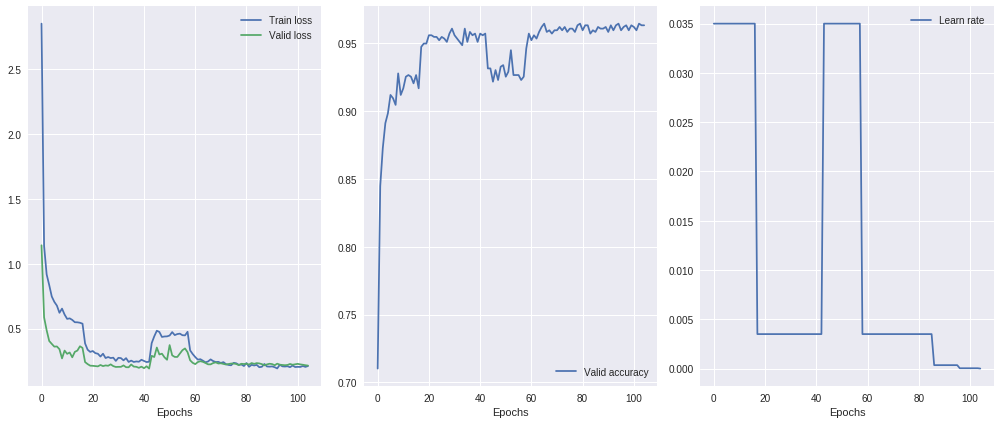

In [12]:
# Witha tyrained model, plot some training stats to see progress
plot_model_stats(model)


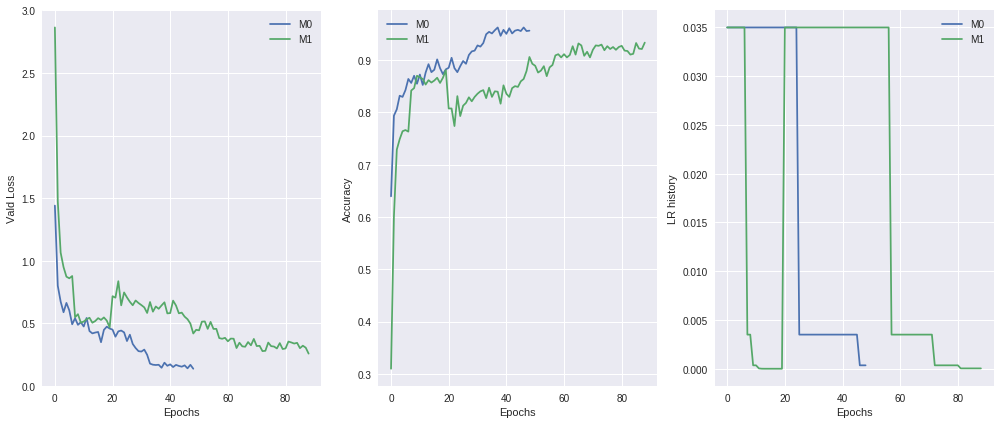

In [13]:
 # This compares several trained model key traiing metrics
 #plot_compare_models(model1, model2)